In [1]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re

In [28]:
def taskA_stats():
    language_mapper = {
        'eng': 'English',
        'hin': 'Hindi',
        'hindi': 'Hindi',
        'mal': 'Malayalam',
        'spanish': 'Spanish',
        'tam': 'Tamil'
    }

    summary = {}
    summary['lang'] = []
    summary['type'] = []

    for file in os.listdir('../dataset/taskA/'):
        file_details = file.split('_')
        summary['lang'].append(language_mapper[file_details[1]])
        summary['type'].append(file_details[3].split('.')[0])
        data = pd.read_csv(f'../dataset/taskA/{file}', index_col=0)
        try:
            data.sort_values(by='category', inplace=True)
        except:
            data.sort_values(by='Labels', inplace=True)
            data.rename(columns={'Labels': 'category'}, inplace=True)
        data['category'].fillna('None', inplace=True)
        counts = data['category'].value_counts().to_dict().items()
        if len(counts) != 3:
            print(file, counts)
        for key, val in counts:
            if key not in summary.keys():
                if key == None or key == 'None':
                    if 'Non-anti-LGBT+ content' not in summary.keys():
                        summary['Non-anti-LGBT+ content'] = []
                    key = 'Non-anti-LGBT+ content'
                elif key == 'Homophobia':
                    if 'Homophobic' not in summary.keys():
                        summary['Homophobic'] = []
                    key = 'Homophobic'
                elif key == 'Transphobia': 
                    if 'Transphobic' not in summary.keys():
                        summary['Transphobic'] = []
                    key = 'Transphobic'
                elif key in ['Non-anti-LGBT+ content', 'Homophobic', 'Transphobic']:
                    summary[key] = []
            summary[key].append(val)
        for key in summary.keys():
            if key not in ['lang', 'type']:
                try:
                    assert len(summary[key]) == len(summary['lang'])
                    assert len(summary[key]) == len(summary['type'])
                except:
                    print(f'"{key}"')
    return summary

def taskB_stats():
    language_mapper = {
        'eng': 'English',
        'hin': 'Hindi',
        'hindi': 'Hindi',
        'mal': 'Malayalam',
        'spanish': 'Spanish',
        'tam': 'Tamil'
    }

    taskB_classes = [
        'None-of-the-above',
        'Homophobic-derogation',
        'Hope-Speech',
        'Counter-speech',
        'Transphobic-derogation',
        'Homophobic-Threatening',
        'Transphobic-Threatening'
    ]

    summary = {}
    summary['lang'] = []
    summary['type'] = []

    for class_name in taskB_classes:
        summary[class_name] = []
    for file in os.listdir('../dataset/taskB/'):
        if file not in ['homo_hindi_7_dev.csv', 'homo_hindi_7_train.csv']:
            file_details = file.split('_')
            summary['lang'].append(language_mapper[file_details[1]])
            summary['type'].append(file_details[3].split('.')[0])
            data = pd.read_csv(f'../dataset/taskB/{file}', index_col=0)
            try:
                data.sort_values(by='category', inplace=True)
            except:
                data.sort_values(by='Labels', inplace=True)
                data.rename(columns={'Labels': 'category'}, inplace=True)
            counts = data['category'].value_counts().to_dict()
            for key in taskB_classes:
                try:
                    summary[key].append(counts[key])
                except:
                    if key == 'None-of-the-above':
                        summary['None-of-the-above'].append(counts['None of categories'])
                    else:
                        print(key)
                        summary[key].append(0)
            for key in summary.keys():
                if key not in ['lang', 'type']:
                    try:
                        assert len(summary[key]) == len(summary['lang'])
                        assert len(summary[key]) == len(summary['type'])
                    except:
                        print(key)
    return summary

In [29]:
def summarize_data(task):
    if task.endswith('A'):
        summary = taskA_stats()
    else:
        summary = taskB_stats()
    task_summary = pd.DataFrame(summary)
    # task_summary['total'] = task_summary[['Non-anti-LGBT+ content', 'Transphobic', 'Homophobic']].sum(axis=1)
        # for col in task_summary.columns.tolist()[2:5]:
    #     task_summary[col] = (task_summary[col] / task_summary['total']) * 100
    # task_summary = task_summary.round(2)
    # task_summary
    groups = task_summary.groupby('type')
    sns.set(style='whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f'Class Distribution by Language for {task}')
    for i, group in enumerate(['train', 'dev']):
        train_summary = groups.get_group(group)
        melted = train_summary.melt(id_vars=['lang', 'type'], var_name='class', value_name='count')
        sns.barplot(ax=axes[i], x='lang', y='count', hue='class', data=melted,  palette='rocket', saturation=0.8)
        for p in axes[i].patches:
            axes[i].text(p.get_x() + p.get_width() / 2., p.get_height(), int(p.get_height()), ha='center', va='bottom')
        axes[i].set(title=f'Class Distribution for {group} set', xlabel='Language', ylabel='Number of examples')
    plt.show()

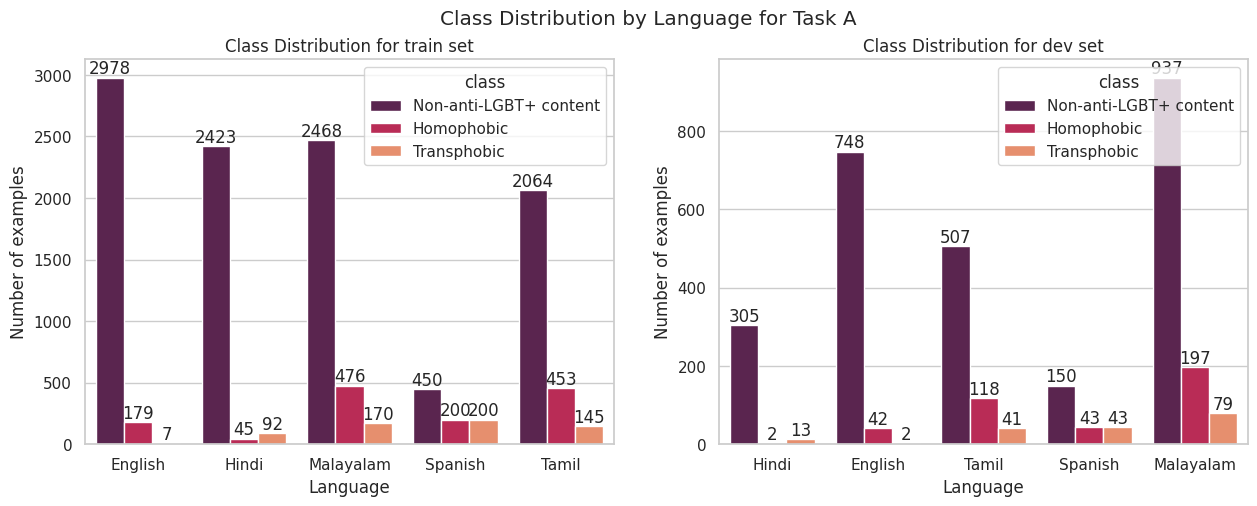

In [31]:
summarize_data('Task A')

Transphobic-Threatening


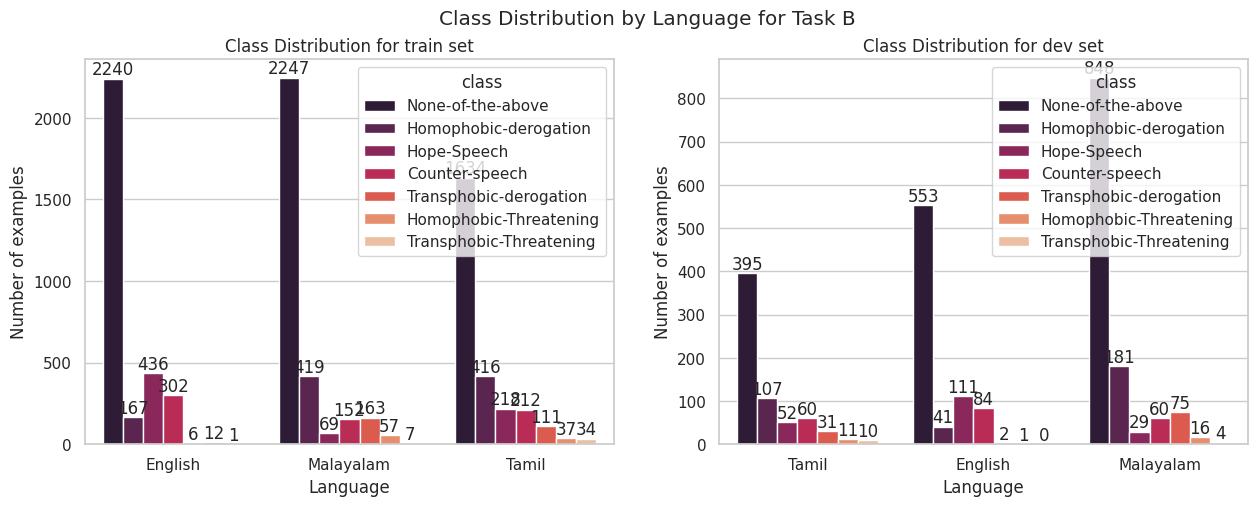

In [6]:
summarize_data('Task B')

* Task B Hindi File does not contain the 7 classes, instead has 3 classes
* class names are not consistent
    * Task A has 'transphobia', 'homophobia' along with 'transphobic' and 'homophobic'
    * Task B has 'None of categories' for the class named 'None-of-the-above'

TODO:
* Check sequence length of each comment

In [66]:
import numpy as np

In [74]:
task = 'taskA'
sent_len = []

for file in os.listdir(os.path.join('../dataset', task)):
    df = pd.read_csv(os.path.join('../dataset', task, file), index_col=0)
    text_col = [col for col in df.columns if col.__contains__('text')][0]
    sent_len.extend(df[text_col].apply(lambda x: len(x)).tolist())

max_sent = max(sent_len)
min_sent = min(sent_len)
print(max_sent, min_sent)

for file in os.listdir(os.path.join('../dataset', task)):
    df = pd.read_csv(os.path.join('../dataset', task, file), index_col=0)
    text_col = [col for col in df.columns if col.__contains__('text')][0]
    for sent in df[df[text_col].apply(lambda x: len(x) == max_sent)][text_col].tolist():
        print(sent + '\n')

for file in os.listdir(os.path.join('../dataset', task)):
    df = pd.read_csv(os.path.join('../dataset', task, file), index_col=0)
    text_col = [col for col in df.columns if col.__contains__('text')][0]
    for sent in df[df[text_col].apply(lambda x: len(x) == min_sent)][text_col].tolist():
        print(sent + '\n')

print(f"The sentence with maximum length is {max_sent} characters long")
print(f"The sentence with minimum length is {min_sent} characters long")
print(f"The average sentence length is {np.mean(sent_len):.2f} characters long")


2722 1
Upper waale ne inhe aesa nahi banaaye he ye to bolte farishto se galti ho gai banane me to. Ek mard our ek aurat our ek apne khusre bhai log. 3 comunity ban gai. But allah ne ya bhagwaan ne ya uper wala keh lo usne inhe khud se alag kar ke rakhne ke liye nahi kaha he inko bhi izzat deni hi he hame q k ye bhi hamari hi tarha sirf our sirf insaan he. Ye koi bimaar ya inse nazre churane jese nai he . Balke ye banane ke time ho gai ek choti si galti he ek nuks he bas. Jese koi per se maazur peda hota he. Koi haath se to koi zuban se to koi aankhse to koi sunne ki taqat se. to wesa hi ye bhi ek pedaaishi nuks he maazuri he bas. To kya ham aese peda hue baccho ko apnate nai apnate hena wese hi ye bhi insaan he jinka badan ka bas ek hissa pura nai hota but inhe bhi ham me hi jaga our izzat ka darja dena ye hukm he allah our uske rasul ka. Per ye baat rahi sirf pedaaishi khusro ki jinki niche ki body incomplete hoti he our upper body aadmi ka pr fitrat aurat ki. Lekin jo log complete bo